# **데이터 전처리**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

#from keras.utils.all_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
# https://kibua20.tistory.com/208 : Python Keras를 이용한 Logistic Regression 방법 및 개념
# https://goldenrabbit.co.kr/2022/07/14/%ED%99%95%EC%8B%A4%ED%9E%88-%EC%95%8C%EC%95%84%EB%91%90%EB%A9%B4-%EB%A7%8C%EC%82%AC%EA%B0%80-%ED%8E%B8%ED%95%B4%EC%A7%80%EB%8A%94-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-10%EA%B0%80%EC%A7%80-%EC%95%8C/
from keras.layers import Dense, Dropout
from keras import optimizers
from keras import losses, metrics
from keras.wrappers.scikit_learn import KerasClassifier

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

import os, sys
workspace = "/content/drive/MyDrive/신한캐피탈/고려대 디지털금융공학/Python 기반 데이터 과학 입문/ku_dfe_group2"     # 자신의 경로 삽입

sys.path.append(workspace)

#train_data_path = os.path.join(workspace, "data/Train_Dataset.csv")
train_data_path = os.path.join(workspace, "data/Full_Dataset.csv") #제공된 Test Dataset과 Sample Submission데이터를 1개 파일로 merge하였음.(각각의 파일을 모두 개별적으로 전처리할 이유가 없지 않나 싶음)
test_data_path = os.path.join(workspace, "data/Test_Dataset.csv")

print(train_data_path)
print(test_data_path)


/content/drive/MyDrive/신한캐피탈/고려대 디지털금융공학/Python 기반 데이터 과학 입문/ku_dfe_group2/data/Full_Dataset.csv
/content/drive/MyDrive/신한캐피탈/고려대 디지털금융공학/Python 기반 데이터 과학 입문/ku_dfe_group2/data/Test_Dataset.csv


In [4]:
df = pd.read_csv(train_data_path, low_memory=False, usecols = all)
df.head()

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Type_Organization,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Default
0,12142509,6750,0.0,0.0,1.0,0.0,0.0,61190.55,3416.85,Alone,...,Yes,Yes,Self-employed,0.568066,0.47878667,NaN,0.0186,63.0,NaN,0
1,12138936,20250,1.0,0.0,1.0,NaN,0.0,15282,1826.55,Alone,...,Yes,Yes,Government,0.563360,0.215068341,NaN,NaN,NaN,NaN,0
2,12181264,18000,0.0,0.0,1.0,0.0,1.0,59527.35,2788.2,Alone,...,Yes,Yes,Self-employed,NaN,0.552794972,0.329655054,0.0742,277.0,0.0,0
3,12188929,15750,0.0,0.0,1.0,1.0,0.0,53870.4,2295.45,Alone,...,Yes,Yes,XNA,NaN,0.135182337,0.631354537,NaN,1700.0,3.0,0
4,12133385,33750,1.0,0.0,1.0,0.0,2.0,133988.4,3547.35,Alone,...,Yes,Yes,Business Entity Type 3,0.508199,0.301181977,0.355638717,0.2021,674.0,1.0,0


In [5]:
# this is a generic function to fix values based on a map passed

def fix_value_by_map(current_value, default, value_map):
    if str(current_value) == 'nan':
        return value_map[default]
    else:
        return current_value

In [6]:
# this is generic function converting to float

def get_floats(values):
    vals = []
    for v in values:
        try:
            vals.append(float(v))
        except:
            vals.append(np.nan)
    return vals

# this is generic function converting to int

def get_integers(values):
    vals = []
    for v in values:
        try:
            vals.append(int(v))
        except:
            vals.append(np.nan)
    return vals

In [7]:
# check for dtypes

# most of data is imported as object and needs to be converted to numeric
df.dtypes

ID                              int64
Client_Income                  object
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                  object
Loan_Annuity                   object
Accompany_Client               object
Client_Income_Type             object
Client_Education               object
Client_Marital_Status          object
Client_Gender                  object
Loan_Contract_Type             object
Client_Housing_Type            object
Population_Region_Relative     object
Age_Days                       object
Employed_Days                  object
Registration_Days              object
ID_Days                        object
Own_House_Age                 float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation              object
Client_Famil

In [8]:
#fix Client_Income

# convert to float
df['Client_Income'] = get_floats(df.Client_Income)
        
# replace nan with proper values
value_map = df.groupby('Default').median()['Client_Income']
df['Client_Income'] = df.apply(lambda row : fix_value_by_map(row['Client_Income'], row['Default'], value_map), axis=1)

In [9]:
# fix Credit_Amount

# convert to float
df['Credit_Amount'] = get_floats(df.Credit_Amount)
        
# remove rows where there is no the amount of the credit
df.dropna(subset=['Credit_Amount'], inplace = True)

In [10]:
# fix Loan_Annuity

# convert to float
df['Loan_Annuity'] = get_floats(df.Loan_Annuity)

# try to get a picture of loan annuity for nan, based on client income and default
value_map = df.groupby(['Client_Income','Default']).mean()['Loan_Annuity']

def get_Loan_Annuity_by_Client_Income_and_Default(loan_annuity, client_income, default, value_map):
    
    new_loan_annuity = loan_annuity
    
    if str(new_loan_annuity) == 'nan':
        for key in value_map.keys():
            if default == key[1]:
                if client_income < key[0]:
                    continue
                else:
                    new_loan_annuity = value_map[key]
                    break
            else:
                continue
    return new_loan_annuity
          
df['Loan_Annuity'] = df.apply(lambda row : get_Loan_Annuity_by_Client_Income_and_Default(row['Loan_Annuity'], row['Client_Income'], row['Default'], value_map), axis=1)

In [11]:
# fix Accompany_Client
# https://teddylee777.github.io/scikit-learn/labelencoder-%EC%82%AC%EC%9A%A9%EB%B2%95
# Categorical 데이터를 Numerical 로 변환하기 위해 LabelEncoder을 사용함
# cat.codes, LabelEncoder, get_dummies 중 Labelencoder를 사용해 봄
df[['Accompany_Client']] = df[['Accompany_Client']].fillna("Alone")

encoder = LabelEncoder()

df.Accompany_Client = encoder.fit_transform(df.Accompany_Client)

In [12]:
# fix Client_Income_Type
df[['Client_Income_Type']] = df[['Client_Income_Type']].fillna("Unknown")

encoder = LabelEncoder()

df.Client_Income_Type = encoder.fit_transform(df.Client_Income_Type)

In [13]:
# fix Car_Owned: consider nan as no car

df[['Car_Owned']] = df[['Car_Owned']].fillna(value=0)

In [14]:
# fix Bike_Owned: consider nan as no bike

df[['Bike_Owned']] = df[['Bike_Owned']].fillna(value=0)

In [15]:
# fix Active_Loan: consider nan as no active loan

df[['Active_Loan']] = df[['Active_Loan']].fillna(value=0)

In [16]:
# fix House_Own: consider nan as no house owned

df[['House_Own']] = df[['House_Own']].fillna(value=0)

In [17]:
# fix Child_Count: consider nan as no house owned

df[['Child_Count']] = df[['Child_Count']].fillna(value=0)

In [18]:
# fix Client_Education
df[['Client_Education']] = df[['Client_Education']].fillna(value='None')

encoder = LabelEncoder()

df.Client_Education = encoder.fit_transform(df.Client_Education) 

In [19]:
# fix Client_Marital_Status
df[['Client_Marital_Status']] = df[['Client_Marital_Status']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Marital_Status = encoder.fit_transform(df.Client_Marital_Status)

In [20]:
# fix Client_Gender
df[['Client_Gender']] = df[['Client_Gender']].fillna(value='Unknown')

encoder = LabelEncoder()

df.Client_Gender = encoder.fit_transform(df.Client_Gender)

In [21]:
# fix Loan_Contract_Type
df[['Loan_Contract_Type']] = df[['Loan_Contract_Type']].fillna(value='Other')
encoder = LabelEncoder()

df.Loan_Contract_Type = encoder.fit_transform(df.Loan_Contract_Type)

In [22]:
#fix Client_Housing_Type
df[['Client_Housing_Type']] = df[['Client_Housing_Type']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Housing_Type = encoder.fit_transform(df.Client_Housing_Type)

In [23]:
# fix Population_Region_Relative
df['Population_Region_Relative'] = get_floats(df.Population_Region_Relative)

df[['Client_Housing_Type']] = df[['Client_Housing_Type']].fillna(value=0)

encoder = LabelEncoder()

df.Population_Region_Relative = encoder.fit_transform(df.Population_Region_Relative)

In [24]:
# fix Age_Days
df['Age_Days'] = get_integers(df.Age_Days)
        
# map missing ages by 'default' column 
value_map = df.groupby('Default').median()['Age_Days']
df['Age_Days'] = df.apply(lambda row : fix_value_by_map(row['Age_Days'], row['Default'], value_map), axis=1)

In [25]:
# fix Employed_Days
df['Employed_Days'] = get_integers(df.Employed_Days)

# map missing Employed Days by 'default' column
value_map = df.groupby('Default').median()['Employed_Days']
df['Employed_Days'] = df.apply(lambda row : fix_value_by_map(row['Employed_Days'], row['Default'], value_map), axis=1)

In [26]:
#fix Registration_Days
df['Registration_Days'] = get_integers(df.Registration_Days)

# map missing Registration Days by 'default' column
value_map = df.groupby('Default').median()['Registration_Days']
df['Registration_Days'] = df.apply(lambda row : fix_value_by_map(row['Registration_Days'], row['Default'], value_map), axis=1)

In [27]:
#fix ID_Days
df['ID_Days'] = get_integers(df.ID_Days)
        
# map missing Id Days by 'default' column
value_map = df.groupby('Default').median()['ID_Days']
df['ID_Days'] = df.apply(lambda row : fix_value_by_map(row['ID_Days'], row['Default'], value_map), axis=1)

In [28]:
# fix Client_Occupation
df[['Client_Occupation']] = df[['Client_Occupation']].fillna(value='Other')

encoder = LabelEncoder()

df.Client_Occupation = encoder.fit_transform(df.Client_Occupation)

In [29]:
# fix Client_Permanent_Match_Tag
encoder = LabelEncoder()

df.Client_Permanent_Match_Tag = encoder.fit_transform(df.Client_Permanent_Match_Tag)  
df.Client_Permanent_Match_Tag.unique()

array([1, 0])

In [30]:
# fix Own_House_Age

# remove for now due to high nans
df.drop(['Own_House_Age'], inplace=True, axis=1)

In [31]:
# fix family members

# suppose nan means zero
df[['Client_Family_Members']] = df[['Client_Family_Members']].fillna(value=0)

In [32]:
#fix Cleint_City_Rating

value_map = df.groupby('Default').median()['Cleint_City_Rating']

df['Cleint_City_Rating'] = df.apply(lambda row : fix_value_by_map(row['Cleint_City_Rating'], row['Default'], value_map), axis=1)

In [33]:
# fix Application_Process_Day

value_map = df.groupby('Default').median()['Application_Process_Day']

df['Application_Process_Day'] = df.apply(lambda row : fix_value_by_map(row['Application_Process_Day'], row['Default'], value_map), axis=1)

In [34]:
# fix Application_Process_Hour

value_map = df.groupby('Default').median()['Application_Process_Hour']

df['Application_Process_Hour'] = df.apply(lambda row : fix_value_by_map(row['Application_Process_Hour'], row['Default'], value_map), axis=1)

In [35]:
# fix Client_Contact_Work_Tag
encoder = LabelEncoder()

df.Client_Contact_Work_Tag = encoder.fit_transform(df.Client_Contact_Work_Tag)

In [36]:
# fix Type organization by splitting between sector and type
df.Type_Organization.unique()

def get_sector(organization_plus_type_value):
    return str(organization_plus_type_value).lower().split('type')[0]

def get_sector_type(organization_plus_type_value):
    try:
        return int(str(organization_plus_type_value).lower().split('type')[1])
    except:
        return 0

# TODO eventually try to join 'XNA' with 'nan' and/or 'Other'?

df['Employment_Sector'] = df.apply(lambda row : get_sector(row['Type_Organization']), axis=1)
df['Employment_Sector_Type'] = df.apply(lambda row : get_sector_type(row['Type_Organization']), axis=1)
df.drop(['Type_Organization'], inplace=True, axis=1)

encoder = LabelEncoder()

df['Employment_Sector'] = encoder.fit_transform(df['Employment_Sector'])

In [37]:
#fix Score_Source_1

df['Score_Source_1'] = get_floats(df.Score_Source_1)

value_map = df.groupby('Default').median()['Score_Source_1']

df['Score_Source_1'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_1'], row['Default'], value_map), axis=1)

In [38]:
#fix Score_Source_2

df['Score_Source_2'] = get_floats(df.Score_Source_2)

value_map = df.groupby('Default').median()['Score_Source_2']

df['Score_Source_2'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_2'], row['Default'], value_map), axis=1)

In [39]:
#fix Score_Source_3

df['Score_Source_3'] = get_floats(df.Score_Source_3)

value_map = df.groupby('Default').median()['Score_Source_3']

df['Score_Source_3'] = df.apply(lambda row : fix_value_by_map(row['Score_Source_3'], row['Default'], value_map), axis=1)

In [40]:
# fix Social_Circle_Default
value_map = df.groupby('Default').mean()['Social_Circle_Default']

df['Social_Circle_Default'] = df.apply(lambda row : fix_value_by_map(row['Social_Circle_Default'], row['Default'], value_map), axis=1)

In [41]:
# fix Phone_Change
value_map = df.groupby('Default').median()['Phone_Change']

df['Phone_Change'] = df.apply(lambda row : fix_value_by_map(row['Phone_Change'], row['Default'], value_map), axis=1)

In [42]:
# fix Credit_Bureau
value_map = df.groupby('Default').median()['Credit_Bureau']

df['Credit_Bureau'] = df.apply(lambda row : fix_value_by_map(row['Credit_Bureau'], row['Default'], value_map), axis=1)

In [43]:
# check all dtypes are fine
df.dtypes

ID                              int64
Client_Income                 float64
Car_Owned                     float64
Bike_Owned                    float64
Active_Loan                   float64
House_Own                     float64
Child_Count                   float64
Credit_Amount                 float64
Loan_Annuity                  float64
Accompany_Client                int64
Client_Income_Type              int64
Client_Education                int64
Client_Marital_Status           int64
Client_Gender                   int64
Loan_Contract_Type              int64
Client_Housing_Type             int64
Population_Region_Relative      int64
Age_Days                      float64
Employed_Days                 float64
Registration_Days             float64
ID_Days                       float64
Mobile_Tag                      int64
Homephone_Tag                   int64
Workphone_Working               int64
Client_Occupation               int64
Client_Family_Members         float64
Cleint_City_

In [44]:
# check for nan : we should not have any of them now...
df.isna().sum()

ID                            0
Client_Income                 0
Car_Owned                     0
Bike_Owned                    0
Active_Loan                   0
House_Own                     0
Child_Count                   0
Credit_Amount                 0
Loan_Annuity                  0
Accompany_Client              0
Client_Income_Type            0
Client_Education              0
Client_Marital_Status         0
Client_Gender                 0
Loan_Contract_Type            0
Client_Housing_Type           0
Population_Region_Relative    0
Age_Days                      0
Employed_Days                 0
Registration_Days             0
ID_Days                       0
Mobile_Tag                    0
Homephone_Tag                 0
Workphone_Working             0
Client_Occupation             0
Client_Family_Members         0
Cleint_City_Rating            0
Application_Process_Day       0
Application_Process_Hour      0
Client_Permanent_Match_Tag    0
Client_Contact_Work_Tag       0
Score_So

In [45]:
# dataset in unbalanced
df.groupby('Default').count()

#print(df['Default'].sum())

,ID,Client_Income,Car_Owned,Bike_Owned,Active_Loan,House_Own,Child_Count,Credit_Amount,Loan_Annuity,Accompany_Client,...,Client_Permanent_Match_Tag,Client_Contact_Work_Tag,Score_Source_1,Score_Source_2,Score_Source_3,Social_Circle_Default,Phone_Change,Credit_Bureau,Employment_Sector,Employment_Sector_Type
Default,,,,,,,,,,,,,,,,,,,,,
0,187030,187030,187030,187030,187030,187030,187030,187030,187030,187030,...,187030,187030,187030,187030,187030,187030,187030,187030,187030,187030
1,9798,9798,9798,9798,9798,9798,9798,9798,9798,9798,...,9798,9798,9798,9798,9798,9798,9798,9798,9798,9798


OverSampling

In [46]:
# oversample the dataset

#X = df.drop(['ID','Default'], axis=1)
#X = df.drop(['ID','Default','Score_Source_1','Score_Source_2','Score_Source_3','Social_Circle_Default'], axis=1)
#X = df.drop(['ID','Default','Score_Source_1','Score_Source_2','Score_Source_3','Social_Circle_Default', 'Credit_Bureau'], axis=1)
#X = df.drop(['ID','Default','Score_Source_1','Score_Source_2','Score_Source_3','Social_Circle_Default', \
#             'ID_Days', 'Mobile_Tag', 'Phone_Change', 'Loan_Annuity'], axis=1)
# X = df.drop(['ID','Default','Score_Source_1','Score_Source_2','Score_Source_3','Social_Circle_Default','Credit_Amount', 'Loan_Annuity'], axis=1)
X = df.drop(['ID','Default','Social_Circle_Default','Score_Source_1','Child_Count','Loan_Annuity'], axis=1)

Y = df.Default
#Y = df['Default']




print('oversampling 전 학습 data 수 :', len(X)) #전체 rows
print('oversampling 전 default data 수 :', Y.sum(axis=0), '(',round(Y.sum(axis=0)/len(X)*100, 2),'%)') #default 수

# oversample dataset
oversample = RandomOverSampler(sampling_strategy=0.1, random_state=0)
#oversample = SMOTE(sampling_strategy=0.1, random_state=0)
# oversample = ADASYN(sampling_strategy=0.1, random_state=0)


# 1)RandomOverSampler:class가 적은 쪽의 데이터를 뻥튀기 시켜주는 방식이다. 동일한 위치에 동일한 데이터를 복사하는 방식이다. 그렇기 때문에, 오버피팅의 위험이 크다.
# 2)SMOTE : k-NN (k-Nearest Neighborhoods)를 기반으로 하는 알고리즘적인 방법이다
# 3)ADASYN : SMOTE의 개선된 버전이다. 주위 데이터의 분포에 따라, 발생시킬 합성 데이터의 수를 좀 더 체계적으로 조절하게 된다.
# <oversample options>
# -minority: 소수 클래스만 resample 한다.
# -not minority: 소수 클래스를 제외한 모든 클래스를 resample한다.
# -not majority, auto (default): 다수 클래스를 제외한 모든 클래스를 resample한다.
# -all: 모든 클래스를 resample한다.
# -float 형식으로 입력한다면 다수 클래스(majority) 대비 소수 클래스(minority)의 비율을 설정할 수 있다.



#SMOTE (Synthetic Minority Over-sampling Technique)는 가장 대중화된 오버샘플링 기법 중 하나로, 
#같은 클래스에 속한 데이터 사이의 거리를 임의의 값으로 내분하는 지점에 새로운 데이터를 생성하는 것
X_over, y_over = oversample.fit_resample(X, Y)
#X_over, y_over = X, Y

print('oversampling 후 학습 data 수 :', len(X_over)) #전체 rows
print('oversampling 후 default data 수 :', y_over.sum(axis=0), '(',round(y_over.sum(axis=0)/len(X_over)*100, 2),'%)') #default 수


# 데이터를 모델링하기 전에는 반드시 스케일링 과정을 거쳐야 한다.
# 스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(overflow)나
# 언더플로우(underflow)를 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜
# 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다.
# - StandardScaler	기본 스케일. 평균과 표준편차 사용
# - MinMaxScaler	최대/최소값이 각각 1, 0이 되도록 스케일링
# - MaxAbsScaler	최대절대값과 0이 각각 1, 0이 되도록 스케일링
# - RobustScaler	중앙값(median)과 IQR(interquartile range) 사용. 아웃라이어의 영향을 최소화



oversampling 전 학습 data 수 : 196828
oversampling 전 default data 수 : 9798 ( 4.98 %)
oversampling 후 학습 data 수 : 205733
oversampling 후 default data 수 : 18703 ( 9.09 %)


In [47]:
scaler = StandardScaler() #사이킷런의 import 모듈 (평균0 분산1로 스케일링)
X_over = scaler.fit_transform(X_over)
#print(X_over)

In [48]:
# generate train test and validation set
# https://jimmy-ai.tistory.com/115
# random_state 인자를 원하는 정수로 설정하면 난수 추출의 seed를 정하여 실행시마다 분리 결과를 고정가능
# stratify 인자를 class 라벨이 들어있는 열로 지정하여 class 라벨(0 or 1) 비율을 고정
#test_size 값을 조정하여 train size와 test size의 비율을 지정할 수 있다.

#https://blog.naver.com/PostView.naver?blogId=siniphia&logNo=221396370872
X_train, X_valid, y_train, y_valid = train_test_split(X_over, y_over, test_size=0.2, stratify=y_over, shuffle=True, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, shuffle=True, random_state=42)


# transform y to categorical => Ont Hot 인코딩 작업 (파라미터 값 위치에만 1(hot)로 셋팅, 나머지는 0으로)
#print(y_train)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_valid = to_categorical(y_valid, 2)
#print(y_train)


In [49]:
def plot_feature_importances(model): #feature importance 그리는 공통함수
    n_features = X_test.data.shape[1]
    plt.figure(figsize=(5, 6))
    plt.barh(range(n_features), model.feature_importances_)
    plt.yticks(np.arange(n_features), X.columns.tolist())
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.ylim(-1, n_features)

In [50]:
def get_clf_eval(y_test, pred) : #confusion matrix 그리는 공통함수 (accuracy, precision, recall value 포함)
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
   
#    print("오차 행렬")
#    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion, xticklabels=list(['Ok(0)','Default(1)']), yticklabels=list(['Ok(0)','Default(1)']),annot=True, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()



---
# **Baseline Model(Sequential NN Model)**


In [ ]:
# compose the NN model
# https://wikidocs.net/32105

model = Sequential()
model.add(Dense(256, activation='relu')) #hidden layer 1
model.add(Dense(256, activation='relu')) #hidden layer 2
model.add(Dropout(0.3))
'''
모델의 과적합 문제는 정규화(regularization) 방법을 주로 사용해 해결하는데,
Dropout 함수는 정규화의 방식중 하나인 드롭아웃을 쉽게 구현해주는 함수이다
모델에 Dropout 함수를 적용할 경우, 과적합을 방지하기 위해 무작위로 특정 노드(입력값)를 0으로 만든다.
물론 드롭아웃은 학습시에만 적용되어 모델 정규화를 위해 사용되어야 하며 테스트시에는 적용되서는 안된다.
Dropout 함수는 이러한 기능을 자동으로 구현해준다.
'''

# https://dbstndi6316.tistory.com/297 옵티마이저 옵션
model.add(Dense(2, activation='softmax')) #output layer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.fit(X_train, y_train, batch_size = 256,  epochs = 80, verbose = True, 
          validation_data=(X_test, y_test), shuffle=True)    
# Evaluate the model accuracy on the validation set.
score = model.evaluate(X_valid, y_valid, verbose=0)

Epoch 1/80
452/452 [==============================] - 5s 10ms/step - loss: 0.2658 - auc: 0.9518 - val_loss: 0.2510 - val_auc: 0.9576
Epoch 2/80
452/452 [==============================] - 7s 16ms/step - loss: 0.2510 - auc: 0.9575 - val_loss: 0.2436 - val_auc: 0.9577
Epoch 3/80
452/452 [==============================] - 4s 9ms/step - loss: 0.2401 - auc: 0.9597 - val_loss: 0.2371 - val_auc: 0.9610
Epoch 4/80
452/452 [==============================] - 4s 9ms/step - loss: 0.2268 - auc: 0.9625 - val_loss: 0.2275 - val_auc: 0.9598
Epoch 5/80
452/452 [==============================] - 4s 9ms/step - loss: 0.2126 - auc: 0.9660 - val_loss: 0.2181 - val_auc: 0.9614
Epoch 6/80
452/452 [==============================] - 4s 9ms/step - loss: 0.2019 - auc: 0.9687 - val_loss: 0.2111 - val_auc: 0.9640
Epoch 7/80
452/452 [==============================] - 4s 9ms/step - loss: 0.1935 - auc: 0.9709 - val_loss: 0.2070 - val_auc: 0.9663
Epoch 8/80
452/452 [==============================] - 5s 11ms/step - loss:

In [ ]:
# predict for train and validation (will be used later for confusion matrix)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_valid_pred = model.predict(X_valid)

1291/1291 [==============================] - 2s 2ms/step


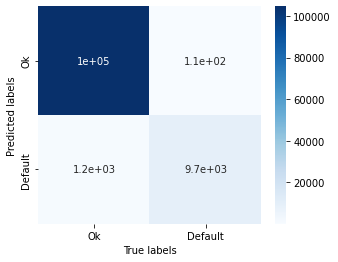

In [ ]:
# plot confusion matrix train TRAIN

y_train_for_cmatrix = []
y_train_preds_for_cmatrix = []
for v in y_train:
    if v[1] > 0.5:
        y_train_for_cmatrix.append(1)
    else:
        y_train_for_cmatrix.append(0)
for v in y_train_pred:
    if v[1] > 0.5:
        y_train_preds_for_cmatrix.append(1)
    else:
        y_train_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_train_for_cmatrix, y_train_preds_for_cmatrix)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

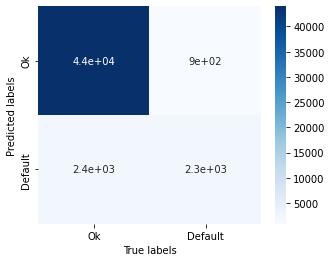

In [ ]:
# plot confusion matrix train TEST

y_test_for_cmatrix = []
y_test_preds_for_cmatrix = []
for v in y_test:
    if v[1] > 0.5:
        y_test_for_cmatrix.append(1)
    else:
        y_test_for_cmatrix.append(0)
for v in y_test_pred:
    if v[1] > 0.5:
        y_test_preds_for_cmatrix.append(1)
    else:
        y_test_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_test_for_cmatrix, y_test_preds_for_cmatrix)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

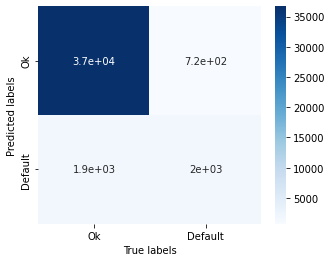

In [ ]:
# plot confusion matrix train VALIDATION (data never seen by the algorithm)

y_valid_for_cmatrix = []
y_valid_preds_for_cmatrix = []
for v in y_valid_pred:
    if v[1] > 0.5:
        y_valid_preds_for_cmatrix.append(1)
    else:
        y_valid_preds_for_cmatrix.append(0)
for v in y_valid:
    if v[1] > 0.5:
        y_valid_for_cmatrix.append(1)
    else:
        y_valid_for_cmatrix.append(0)
        
confusion_mtx = confusion_matrix(y_valid_for_cmatrix,y_valid_preds_for_cmatrix)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
#https://velog.io/@ljs7463/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EB%AA%A8%EB%8D%B8-%ED%8F%89%EA%B0%80%EC%A0%95%EB%B0%80%EB%8F%84%EC%9E%AC%ED%98%84%EC%9C%A8f1-score%EB%93%B1
# accuracy 만으로 모델의 성능을 판단하는 것은 적합하지 않다.
#imbalanced한 label값 분포에서는 Precision, Recall, F1 Score 등의 평가지표를 고려해야 한다.

# print accuracy and f1 score for training data
print(accuracy_score(y_train_for_cmatrix, y_train_preds_for_cmatrix), f1_score(y_train_for_cmatrix, y_train_preds_for_cmatrix))
# print accuracy and f1 score for validation data
print(accuracy_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix), f1_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix))
# print accuracy and f1 score for test data
print(accuracy_score(y_test_for_cmatrix, y_test_preds_for_cmatrix), f1_score(y_test_for_cmatrix, y_test_preds_for_cmatrix))

0.988861985472155 0.937879810938555
0.9357642672090264 0.5958872810357959
0.9337772397094432 0.5827612509534706


In [ ]:
print(classification_report(y_test_for_cmatrix, y_test_preds_for_cmatrix, target_names=['OK','Default']))

from sklearn.metrics import roc_curve, roc_auc_score

roc_score = roc_auc_score(y_test, y_test_pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

              precision    recall  f1-score   support

          OK       0.95      0.98      0.96     44887
     Default       0.72      0.49      0.58      4673

    accuracy                           0.93     49560
   macro avg       0.83      0.74      0.77     49560
weighted avg       0.93      0.93      0.93     49560

ROC AUC 값 : 0.8608


---
# **Decision Tree 모델**
---






In [ ]:
from sklearn.tree import DecisionTreeClassifier 

#depth를 조절하여 overfitting 개선 가능함
#tree = DecisionTreeClassifier(max_depth=15,min_samples_split=2, random_state=0)
tree = DecisionTreeClassifier(random_state=0, min_samples_leaf=2, min_samples_split=3, max_features=31, max_depth=None)
tree.fit(X_train, y_train)

print("훈련 세트 정확도: {:.3f}".format(tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(tree.score(X_test, y_test)))
print("검증 세트 정확도: {:.3f}".format(tree.score(X_valid, y_valid)))


훈련 세트 정확도: 0.976
테스트 세트 정확도: 0.913
검증 세트 정확도: 0.915


In [ ]:
# predict for train and validation (will be used later for confusion matrix)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
y_valid_pred = tree.predict(X_valid)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_score = roc_auc_score(y_test, y_test_pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

ROC AUC 값 : 0.8131


In [ ]:
# from sklearn.tree import export_graphviz

# # .dot 파일로 export 해줍니다
# export_graphviz(tree, out_file="tree.dot", class_names=["Default", "OK"],
#                 feature_names=X.columns.tolist(),
#                 impurity=False, filled=True)

# # 생성된 .dot 파일을 .png로 변환
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])


# from IPython.display import Image
# Image(filename = 'decistion-tree.png')

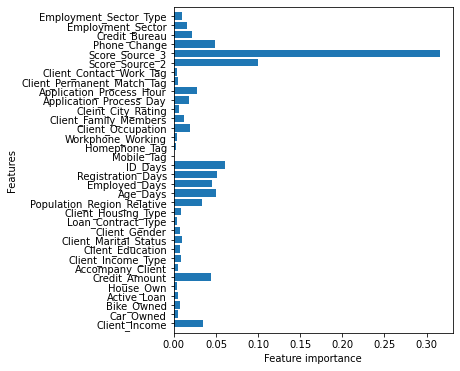

In [ ]:
plot_feature_importances(tree)
#https://tensorflow.blog/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/2-3-5-%EA%B2%B0%EC%A0%95-%ED%8A%B8%EB%A6%AC/
#https://nicola-ml.tistory.com/93

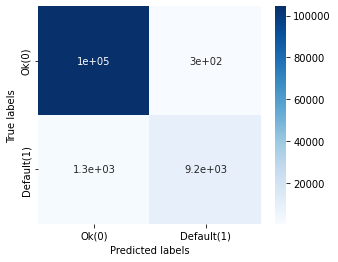

In [ ]:
# plot confusion matrix train TRAIN

y_train_for_cmatrix = []
y_train_preds_for_cmatrix = []
for v in y_train:
    if v[1] > 0.5:
        y_train_for_cmatrix.append(1)
    else:
        y_train_for_cmatrix.append(0)
for v in y_train_pred:
    if v[1] > 0.5:
        y_train_preds_for_cmatrix.append(1)
    else:
        y_train_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_train_for_cmatrix, y_train_preds_for_cmatrix)
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=list(['Ok(0)','Default(1)']), yticklabels=list(['Ok(0)','Default(1)']),annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

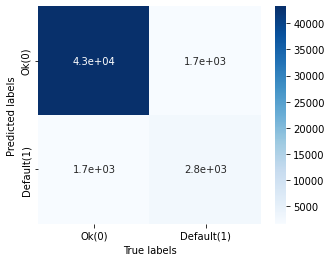

In [ ]:
# plot confusion matrix train TEST

y_test_for_cmatrix = []
y_test_preds_for_cmatrix = []
for v in y_test:
    if v[1] > 0.5:
        y_test_for_cmatrix.append(1)
    else:
        y_test_for_cmatrix.append(0)
for v in y_test_pred:
    if v[1] > 0.5:
        y_test_preds_for_cmatrix.append(1)
    else:
        y_test_preds_for_cmatrix.append(0)

        
confusion_mtx = confusion_matrix(y_test_for_cmatrix, y_test_preds_for_cmatrix)
plt.figure(figsize=(5,4))
#sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
sns.heatmap(confusion_mtx, xticklabels=list(['Ok(0)','Default(1)']), yticklabels=list(['Ok(0)','Default(1)']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

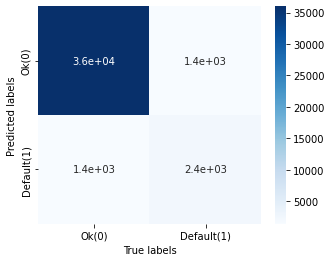

In [ ]:
# plot confusion matrix train VALIDATION (data never seen by the algorithm)

y_valid_for_cmatrix = []
y_valid_preds_for_cmatrix = []
for v in y_valid_pred:
    if v[1] > 0.5:
        y_valid_preds_for_cmatrix.append(1)
    else:
        y_valid_preds_for_cmatrix.append(0)
for v in y_valid:
    if v[1] > 0.5:
        y_valid_for_cmatrix.append(1)
    else:
        y_valid_for_cmatrix.append(0)
        
confusion_mtx = confusion_matrix(y_valid_for_cmatrix,y_valid_preds_for_cmatrix)
plt.figure(figsize=(5,4))
#sns.heatmap(confusion_mtx, xticklabels=list(['Ok','Default']), yticklabels=list(['Ok','Default']),annot=True, cmap='Blues')
sns.heatmap(confusion_mtx, xticklabels=list(['Ok(0)','Default(1)']), yticklabels=list(['Ok(0)','Default(1)']),annot=True, cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
# print accuracy and f1 score for training data
print(accuracy_score(y_train_for_cmatrix, y_train_preds_for_cmatrix), f1_score(y_train_for_cmatrix, y_train_preds_for_cmatrix))
# print accuracy and f1 score for test data
print(accuracy_score(y_test_for_cmatrix, y_test_preds_for_cmatrix), f1_score(y_test_for_cmatrix, y_test_preds_for_cmatrix))
# print accuracy and f1 score for validation data
print(accuracy_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix), f1_score(y_valid_for_cmatrix, y_valid_preds_for_cmatrix))


0.9860949570349796 0.9196750902527077
0.931302657161374 0.6204967554262697
0.9319999027875665 0.627132196162047


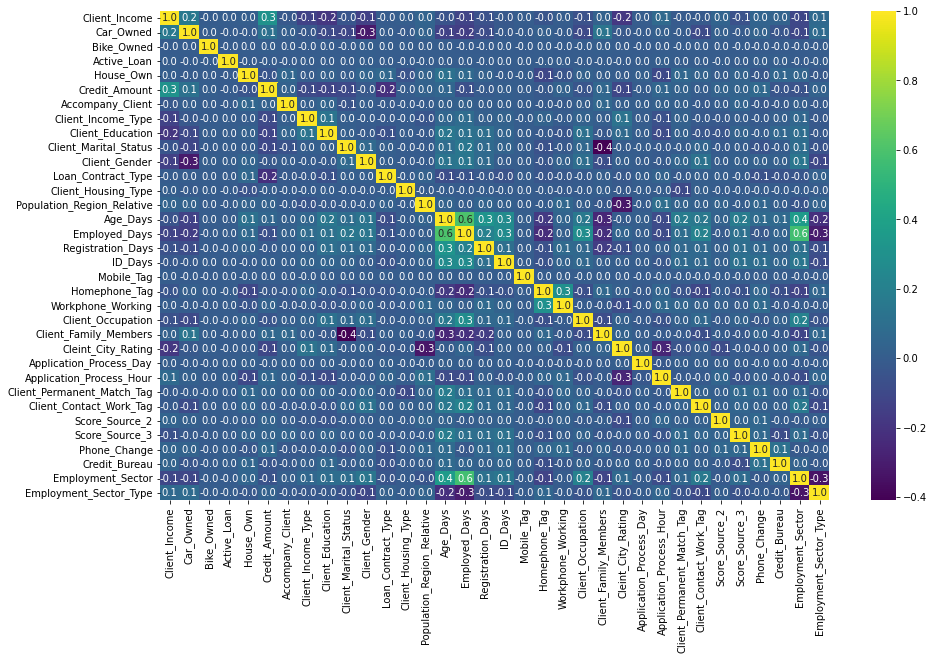

In [ ]:
#feature별 상관관계 시각화
df_corr = X.corr()
plt.figure(figsize = (15,9))
sns.heatmap(df_corr, cmap='viridis', annot=True, fmt='.1f')
plt.show()

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')
print(classification_report(y_test, y_test_pred, target_names=['OK','Default']))

              precision    recall  f1-score   support

          OK       0.97      0.94      0.96     44887
     Default       0.62      0.62      0.62      4489

   micro avg       0.94      0.91      0.93     49376
   macro avg       0.80      0.78      0.79     49376
weighted avg       0.94      0.91      0.93     49376
 samples avg       0.91      0.91      0.91     49376



# **Logistic Regression**

정확도: 0.9089, 정밀도: 0.4536, 재현율: 0.0098


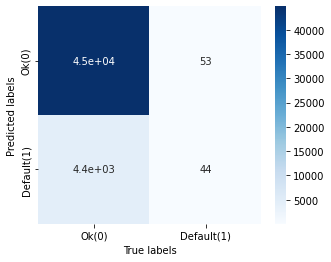

              precision    recall  f1-score   support

          OK       0.91      1.00      0.95     44887
     Default       0.45      0.01      0.02      4489

    accuracy                           0.91     49376
   macro avg       0.68      0.50      0.49     49376
weighted avg       0.87      0.91      0.87     49376

ROC AUC 값 : 0.5043


In [ ]:
# https://velog.io/@gayeon/%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D-%EC%B4%88%EB%B3%B4%EC%9E%90%EB%A5%BC-%EC%9C%84%ED%95%9C-Logistic-Regression-with-Scikit-Learn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

# 학습/예측/평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train[:,1])
lr_pred = lr_clf.predict(X_test)

# print(lr_pred.shape)
# print(y_test.shape)
# print(lr_pred)
# print(y_test[:,1])

get_clf_eval(y_test[:,1],lr_pred)
#print(classification_report(y_test[:,1].reshape(-1,1), lr_pred, target_names=['OK','Default']))
print(classification_report(y_test[:,1], lr_pred, target_names=['OK','Default']))

#import warnings
#warnings.filterwarnings(action='ignore')
#print(classification_report(y_test[:,1].reshape(-1,1), lr_pred, target_names=['OK','Default']))

roc_score = roc_auc_score(y_test[:,1].reshape(-1,1), lr_pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

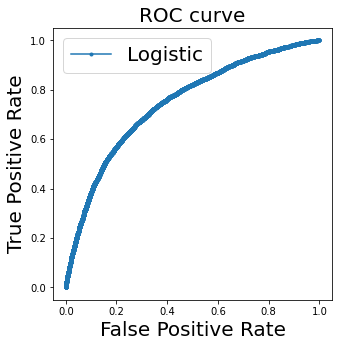

              precision    recall  f1-score   support

          OK       0.91      1.00      0.95     44887
     Default       0.45      0.01      0.02      4489

    accuracy                           0.91     49376
   macro avg       0.68      0.50      0.49     49376
weighted avg       0.87      0.91      0.87     49376



In [ ]:

probs = lr_clf.predict_proba(X_test)[:,1]
#print(probs.shape)
#print(probs)
model_fpr, model_tpr, threshold1 = roc_curve(y_test[:,1], probs)
plt.figure(figsize = (5,5))
plt.plot(model_fpr, model_tpr, marker = '.', label = "Logistic")

plt.xlabel("False Positive Rate", size = 20)
plt.ylabel("True Positive Rate", size = 20)

plt.legend(fontsize = 20)

plt.title("ROC curve", size = 20)
plt.show()

# threshold 값 변경하기 - Binarizer
from sklearn.preprocessing import Binarizer

binarizer = Binarizer(threshold=0.5).fit(probs.reshape(-1,1))
pred_bin = binarizer.transform(probs.reshape(-1,1))

binarizer.threshold, pred_bin

print(classification_report(y_test[:,1], pred_bin, target_names=['OK','Default']))

# K-Nearest Neighbors Classifier (KNN Model)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, roc_auc_score
#https://todayisbetterthanyesterday.tistory.com/21

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
   
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}")

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion, xticklabels=list(['Ok(0)','Default(1)']), yticklabels=list(['Ok(0)','Default(1)']),annot=True, cmap='Blues')
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

In [ ]:
# cross-validation library
from sklearn.model_selection import cross_val_score

# k_range = range(1,100)              # k를 1~100까지 고려하여 최적의 k를 찾을 것이다.
# k_score = []                        # 각 k들의 성능을 비교하기 위한 리스트생성이다.

#kn_clf = KNeighborsClassifier(n_neighbors=50)
kn_clf = KNeighborsClassifier(n_neighbors=2)

# for k in k_range :
# 	knn = KNeighborsClassifier(k)
# 	scores = cross_val_score(knn,X_test,y_test,cv=10,scoring = "accuracy")    # 10-fold cross-validation
# 	k_score.append(scores.mean())                    # 10-fold 각각 정확도의 평균으로 성능계산 

# plt.plot(k_range, k_score)
# plt.xlabel('Value of K for KNN')
# plt.ylabel('Cross-Validation Accuracy')
# plt.show()

kn_clf.fit(X_train, y_train) 
kn_pred = kn_clf.predict(X_test)

정확도: 0.9171, 정밀도: 0.5820, 재현율: 0.3132


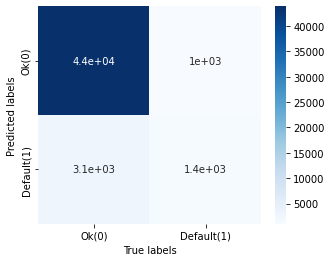

              precision    recall  f1-score   support

          OK       0.93      0.98      0.96     44887
     Default       0.58      0.31      0.41      4489

    accuracy                           0.92     49376
   macro avg       0.76      0.65      0.68     49376
weighted avg       0.90      0.92      0.91     49376



In [ ]:
#print(y_test[:,1])
#print(kn_pred)
get_clf_eval(y_test[:,1], kn_pred[:,1])
print(classification_report(y_test[:,1], kn_pred[:,1], target_names=['OK','Default']))

# XGBoost(eXtra Gradient Boost) MODEL (Ensemble)

In [ ]:
from xgboost import XGBClassifier

# 모델 선언 예시
# xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=10, random_state = 32)
xgb_clf = XGBClassifier(n_estimators=500, learning_rate=0.3, max_depth=15, random_state = 32)
# n_estimators : 학습 모델의 수, 많아질수록 성능 향상의 가능성이 있으나, 속도가 느려짐
# learning_rate : 학습률, 너무 크면 gradient 발산의 가능성이 있으며, 너무 작으면 학습이 느림
# max_depth : 최대 탐색 깊이, 너무 크면 과적합의 가능성, 너무 작으면 학습 성능 저하
# min_samples_split : 분할 종료 최소 샘플 수, 큰 수면 과적합을 막지만 학습 성능 저하 가능성
# min_samples_leaf : leaf node가 되기 위한 최소 샘플 수, min_samples_split과 비슷한 용도
# random_state : 특정 숫자로 고정 시에 실행 시마다 고정된 결과 반환


# https://leehah0908.tistory.com/17
# Bagging vs Boosting 그리고 기타 앙상블 모델 참고해보자

In [ ]:
xgb_clf.fit(X_train, y_train[:,1])
xgb_pred = xgb_clf.predict(X_test)

정확도: 0.9712, 정밀도: 0.9370, 재현율: 0.7320


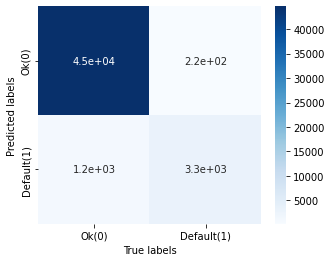

              precision    recall  f1-score   support

          OK       0.97      1.00      0.98     44887
     Default       0.94      0.73      0.82      4489

    accuracy                           0.97     49376
   macro avg       0.96      0.86      0.90     49376
weighted avg       0.97      0.97      0.97     49376



In [ ]:
get_clf_eval(y_test[:,1], xgb_pred)
print(classification_report(y_test[:,1], xgb_pred, target_names=['OK','Default']))

# LightGBM MODEL (Ensemble)

In [52]:
from lightgbm import LGBMClassifier

# LGBMClassifier 모델 선언 후 Fitting
# lgb_clf = LGBMClassifier(n_estimators=500, learning_rate=0.25, max_depth=100, random_state = 32)

# lgb_clf = LGBMClassifier(n_estimators=500, learning_rate=0.25, max_depth=20, random_state = 32, objective='binary', boosting_type='goss', num_leaves=200)
# lgb_clf = LGBMClassifier(n_estimators=500, learning_rate=0.25, max_depth=20, random_state = 32, objective='binary', boosting_type='gbdt', num_leaves=100, metric='binary_logloss', sub_feature=0.9)
#lgb_clf = LGBMClassifier(n_estimators=500, learning_rate=0.25, max_depth=20, random_state = 32, objective='binary', boosting_type='gbdt', num_leaves=150, metric='mae', sub_feature=0.9, min_data=500, num_boost_round=500)
lgb_clf = LGBMClassifier(n_estimators=500, learning_rate=0.45, max_depth=20, random_state = 32, objective='binary', boosting_type='gbdt', num_leaves=200, metric='mae', sub_feature=0.5, min_data=500, reg_alpha=0.3, num_boost_round=200,min_data_in_leaf=300,max_cat_group=1000)
# n_estimators (int) : 내부에서 생성할 결정 트리의 개수
# max_depth (int) : 생성할 결정 트리의 높이
# learning_rate (float) : 훈련량, 학습 시 모델을 얼마나 업데이트할지 결정하는 값
# colsample_bytree (float) : 열 샘플링에 사용하는 비율
# subsample (float) : 행 샘플링에 사용하는 비율
# reg_alpha (float) : L1 정규화 계수
# reg_lambda (float) : L2 정규화 계수
# boosting_type (str) : 부스팅 방법 (gbdt / rf / dart / goss)
# random_state (int) : 내부적으로 사용되는 난수값
# n_jobs (int) : 병렬처리에 사용할 CPU 수
# https://nurilee.com/2020/04/03/lightgbm-definition-parameter-tuning/

In [53]:
lgb_clf.fit(X_train, y_train[:,1])

# Fitting된 모델로 x_valid를 통해 예측을 진행
# 0 or 1로 예측을 할 때
lgb_pred = lgb_clf.predict(X_test)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


정확도: 0.9681, 정밀도: 0.8983, 재현율: 0.7320


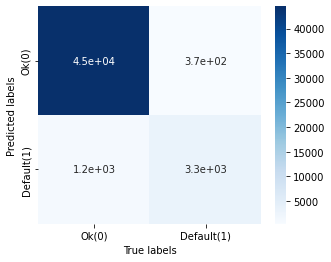

              precision    recall  f1-score   support

          OK       0.97      0.99      0.98     44887
     Default       0.90      0.73      0.81      4489

    accuracy                           0.97     49376
   macro avg       0.94      0.86      0.89     49376
weighted avg       0.97      0.97      0.97     49376



In [54]:
get_clf_eval(y_test[:,1], lgb_pred)
print(classification_report(y_test[:,1], lgb_pred, target_names=['OK','Default']))

ROC AUC 값 : 0.8619


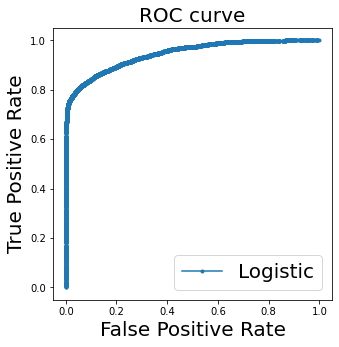

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_score = roc_auc_score(y_test[:,1].reshape(-1,1), lgb_pred)
print('ROC AUC 값 : {:.4f}'.format(roc_score))

y_pred_proba = lgb_clf.predict_proba(X_test) # 0 ~ 1 사이의 확률값으로 예측

model_fpr, model_tpr, threshold1 = roc_curve(y_test[:,1], y_pred_proba[:,1])
plt.figure(figsize = (5,5))
plt.plot(model_fpr, model_tpr, marker = '.', label = "Logistic")

plt.xlabel("False Positive Rate", size = 20)
plt.ylabel("True Positive Rate", size = 20)

plt.legend(fontsize = 20)

plt.title("ROC curve", size = 20)
plt.show()

# RandomForestClassifier (Bagging Ensemble)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# RandomForestClassifier 모델 선언 후 Fitting
rf_clf = RandomForestClassifier(n_estimators=500, max_depth=30, random_state = 32)
#rf_clf = RandomForestClassifier(n_estimators=500, max_depth=20, random_state = 32, class_weight='balanced')

# n_estimators (int) : 내부에서 생성할 결정 트리의 개수
# crierion (str) : 정보량 계산 시 사용할 수식 (분류 모델 : gini / entropy, 회귀 모델 : mse / rmse)
# max_depth (int) : 생성할 트리의 높이
# min_samples_split (int) : 분기를 수행하는 최소한의 데이터 수
# max_leaf_nodes (int) : 리프 노드에서 가지고 있을 수 있는 최대 데이터 수
# random_state (int) : 내부적으로 사용되는 난수값
# n_jobs (int) : 병렬처리에 사용할 CPU 수
# class_weight (dict) : 학습 시 클래스의 비율에 맞춰 손실값에 가중치를 부여 (분류 모델에서만 쓰임)

rf_clf.fit(X_train, y_train)

# Fitting된 모델로 x_valid를 통해 예측을 진행
rf_pred = rf_clf.predict(X_test)

정확도: 0.7704, 정밀도: 0.2688, 재현율: 0.8866


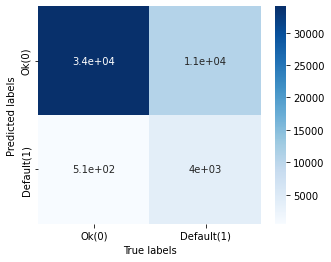

              precision    recall  f1-score   support

          OK       0.99      0.76      0.86     44887
     Default       0.27      0.89      0.41      4489

    accuracy                           0.77     49376
   macro avg       0.63      0.82      0.63     49376
weighted avg       0.92      0.77      0.82     49376



In [ ]:
get_clf_eval(y_test[:,1], rf_pred[:,1])
print(classification_report(y_test[:,1], rf_pred[:,1], target_names=['OK','Default']))


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

roc_score = roc_auc_score(y_test[:,1].reshape(-1,1), rf_pred[:,1])

print('ROC AUC 값 : {:.4f}'.format(roc_score))

y_pred_proba = rf_clf.predict_proba(X_test) # 0 ~ 1 사이의 확률값으로 예측


ROC AUC 값 : 0.8227


# Support Vector Machine (SVM)

In [ ]:
# https://leehah0908.tistory.com/12 참고해보자
from sklearn import svm

# parameters
C = 2
gamma = 1.2
degree = 5
kernel = 'linear'

#svm_clf = svm.SVC(kernel='poly')
svm_clf = svm.SVC(kernel=kernel, class_weight={1:C}, degree=degree, random_state=1)
# linear : 선형 함수
# poly : 다항식 함수
# RBF : 방사 기저 함수 (가우시안)
# Hyper-Tangent : 쌍곡선 탄젠트 함수
# => 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
# ------------------------------------
# C (float) : 얼마나 모델에 규제를 넣을지 결정하는 값 (값이 작을수록 모델에 규제가 높아진다. Hard or Soft 결정 파라미터)
# degree (int) : Poly kernel 사용 시 차수를 결정하는 값
# kernel (str) : kernel trick에 사용할 kernel 종류
# random_state (int) : 내부적으로 사용되는 난수 값
# class_weight (dict) : 학습 시 클래스의 비율에 맞춰 손실 값에 가중치 부여 (분류 모델에서만 쓰인다.)
# gamma (float) : 모델이 생성하는 경계가 복잡해지는 정도 (값이 커질수록 데이터 포인터가 영향력을 행사하는 거리가 짧아져서 경계가 복잡해진다.)

svm_clf.fit(X_train, y_train[:,1])
svm_pred = svm_clf.predict(X_test)


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

#print(svm_pred.shape)

get_clf_eval(y_test[:,1], svm_pred)
print(classification_report(y_test[:,1], svm_pred, target_names=['OK','Default']))

# AdaBoost Model

In [ ]:
#https://zephyrus1111.tistory.com/195 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 

adab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=None),
                              n_estimators=500,
                              random_state=10,
                              learning_rate=0.1)
    
adab_clf.fit(X_train, y_train[:,1])
adab_pred = adab_clf.predict(X_test)

정확도: 0.9605, 정밀도: 0.9392, 재현율: 0.6053


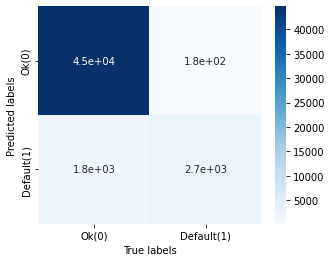

              precision    recall  f1-score   support

          OK       0.96      1.00      0.98     44887
     Default       0.94      0.61      0.74      4489

    accuracy                           0.96     49376
   macro avg       0.95      0.80      0.86     49376
weighted avg       0.96      0.96      0.96     49376



In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

#print(adab_pred.shape)
get_clf_eval(y_test[:,1], adab_pred)
print(classification_report(y_test[:,1], adab_pred, target_names=['OK','Default']))

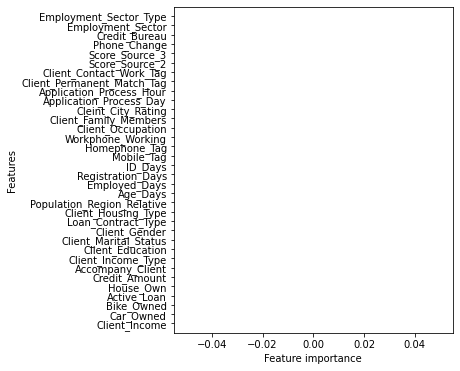

In [ ]:
plot_feature_importances(adab_clf) #학습된 모델에 따라서 feature별 importance 값은 달라진다

# GBM Model(Gradient Boost Machine)

In [ ]:
#AdaBoost와 비슷하나 가중치 업데이트를 경사하강법(Gradient Descent) 를 이용한다는 점이 큰 차이점이다.
from sklearn.ensemble import GradientBoostingClassifier
#grdb_clf = GradientBoostingClassifier()
grdb_clf = GradientBoostingClassifier(n_estimators=100, criterion='friedman_mse', max_depth=5, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
# grdb_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, criterion='friedman_mse', max_depth=2, max_leaf_nodes=None, min_samples_split=2, min_samples_leaf=1, max_features=None)
# gbm_clf = GradientBoostingClassifier(learning_rate=0.01, n_estimators=150, criterion='friedman_mse', max_depth=None, max_features=None, subsample=0.5) # 50% 비율만큼 subsample 하여 overfitting 줄이는 효과

gbm_clf.fit(X_train, y_train[:,1])
grdb_pred = gbm_clf.predict(X_test)

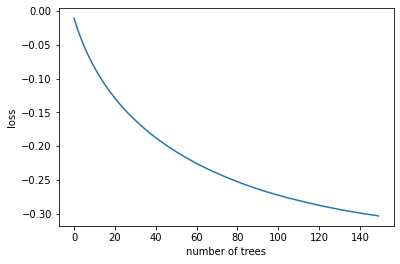

In [ ]:
# subsample 매개변수를 기본값 1.0보다 작은 값으로 지정하면 훈련 데이터셋에서 subsample 매개변수에 지정된 비율만큼 랜덤하게 샘플링하여 트리를 훈련합니다.
# 이를 확률적 그레이디언트 부스팅이라고 부릅니다. 이는 랜덤 포레스트나 에이다부스트의 부트스트랩 샘플링과 비슷하게 과대적합을 줄이는 효과를 냅니다.
# 또한, 남은 샘플을 사용하여 OOB 점수를 계산할 수 있습니다. subsample 매개변수가 1.0보다 작을 때 그레이디언트 부스팅 객체의 oob_improvement_ 속성에 이전 트리의 OOB 손실 값에서 현재 트리의 OOB 손실을 뺀 값이 기록되어 있습니다.
# 이 값에 음수를 취해서 누적하면 트리가 추가되면서 과대적합되는 지점을 찾을 수 있습니다.
oob_loss = np.cumsum(-gbm_clf.oob_improvement_)
plt.plot(range(150), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')
plt.show()

정확도: 0.9598, 정밀도: 0.9549, 재현율: 0.5854


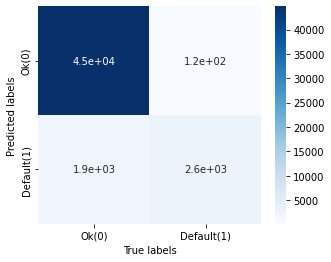

              precision    recall  f1-score   support

          OK       0.96      1.00      0.98     44887
     Default       0.95      0.59      0.73      4489

    accuracy                           0.96     49376
   macro avg       0.96      0.79      0.85     49376
weighted avg       0.96      0.96      0.96     49376



In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

#print(adab_pred.shape)
get_clf_eval(y_test[:,1], grdb_pred)
print(classification_report(y_test[:,1], grdb_pred, target_names=['OK','Default']))